In [1]:
# imports
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from seldon_core.seldon_client import SeldonClient

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Function to caluclate intersection over union of prediction
def iou(pred, label):
    intersection = (pred * label).sum()
    union = pred.sum() + label.sum() - intersection
    if pred.sum() == 0 and label.sum() == 0:
        return 1
    return intersection / union

# Function to create tensor for image and mask
def PairedToTensor(sample):
    img, mask = sample
    img = np.array(img)
    mask = np.expand_dims(mask, -1)
    img = np.moveaxis(img, -1, 0)
    mask = np.moveaxis(mask, -1, 0)
    img, mask = torch.FloatTensor(img), torch.FloatTensor(mask)
    img = img/255
    mask = mask/255
    return img, mask

## Set up seldon client

In [108]:
# set seldon IP and image for payload
seldon_ip = "10.10.160.183"

# setup seldon clients
sc = SeldonClient(
    deployment_name="brain-mri-deploy", namespace="seldon", gateway_endpoint=f"{seldon_ip}:80", gateway="istio")

sc_update = SeldonClient(
    deployment_name="brain-mri-update", namespace="seldon", gateway_endpoint=f"{seldon_ip}:80", gateway="istio")

## Get a sample image

In [171]:
# Load image and maskbra
#image = Image.open("../../jordan/brain-mri/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_18.tif")
#mask = Image.open("../../jordan/brain-mri/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_18_mask.tif")

#image = Image.open("../../jordan/brain-mri/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_18.tif")
#mask = Image.open("../../jordan/brain-mri/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_18_mask.tif")

#image = Image.open("../../jordan/brain-mri/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_9.tif")
#mask = Image.open("../../jordan/brain-mri/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_9_mask.tif")

#image = Image.open("../../jordan/brain-mri/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_10.tif")
#mask = Image.open("../../jordan/brain-mri/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_10_mask.tif")

image = Image.open("../../jordan/brain-mri/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_20.tif")
mask = Image.open("../../jordan/brain-mri/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_20_mask.tif")


# Create tuple
sample = (image, mask)

# Create tensors from tuple
tensor_sample = PairedToTensor(sample)

# Convert image tensor to image array for Seldon
img_array = tensor_sample[0].numpy()

## Get a prediction from seldon, plot it

In [172]:
# Make prediction
out = sc.predict(transport="rest", data=img_array)
out_update = sc_update.predict(transport="rest", data=img_array)

In [173]:
# Get tensor from output of prediction
if out.success:
    shape = out.response["data"]["tensor"]["shape"]
    values = out.response["data"]["tensor"]["values"]
    output = torch.Tensor(np.array(values).reshape(shape))
    
    
# Get tensor from output of prediction
if out_update.success:
    shape_update = out_update.response["data"]["tensor"]["shape"]
    values_update = out_update.response["data"]["tensor"]["values"]
    output_update = torch.Tensor(np.array(values_update).reshape(shape_update))

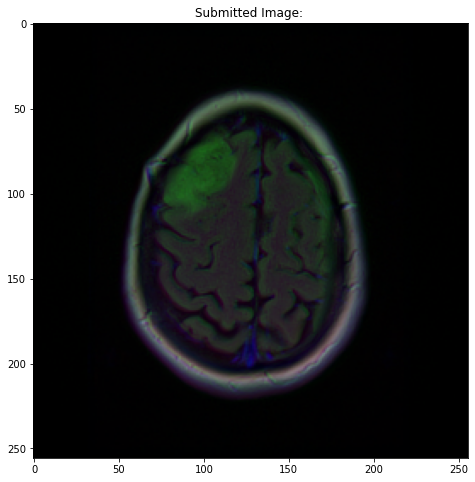

In [174]:
plt.figure(figsize=(8,8))
plt.title(f'Submitted Image: ')
plt.imshow(tensor_sample[0].permute(1, 2, 0))
#plt.figure(figsize = (15,15))



Intersection over Union (IoU): 0.8161702156066895


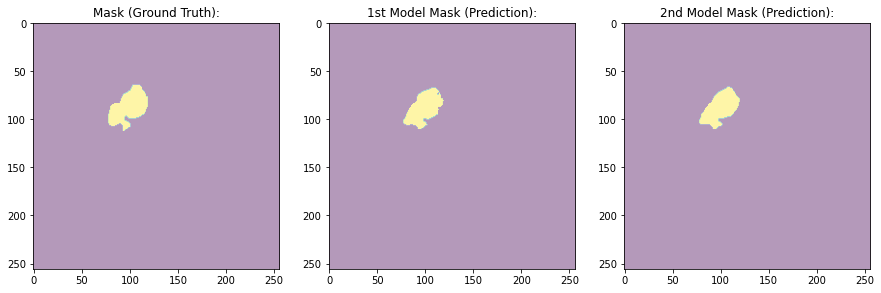

In [175]:
f, axarr = plt.subplots(1,3, figsize=(15, 15))
#axarr[0].imshow(tensor_sample[0].permute(1, 2, 0))
axarr[0].imshow(tensor_sample[1].permute(1, 2, 0), alpha=0.4)
axarr[0].title.set_text(f'Mask (Ground Truth):')
#axarr[1].imshow(tensor_sample[0].permute(1, 2, 0))
axarr[1].imshow(output.permute(1, 2, 0), alpha=0.4)
axarr[1].title.set_text(f'1st Model Mask (Prediction):')

axarr[2].imshow(output_update.permute(1, 2, 0), alpha=0.4)
axarr[2].title.set_text(f'2nd Model Mask (Prediction):')

print(f'Intersection over Union (IoU): {iou(output, tensor_sample[1])}')

Intersection over Union (IoU): 0.8161702156066895


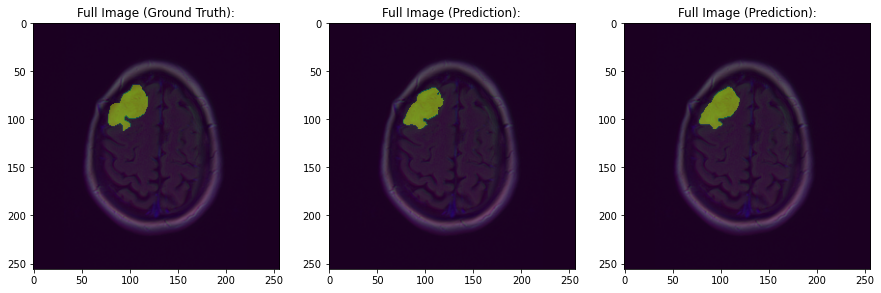

In [176]:
# Display groundtruth and prediction, call iou function and display iou
f, axarr = plt.subplots(1,3, figsize=(15, 15))
axarr[0].imshow(tensor_sample[0].permute(1, 2, 0))
axarr[0].imshow(tensor_sample[1].permute(1, 2, 0), alpha=0.4)
axarr[0].title.set_text(f'Full Image (Ground Truth):')
axarr[1].imshow(tensor_sample[0].permute(1, 2, 0))
axarr[1].imshow(output.permute(1, 2, 0), alpha=0.4)
axarr[1].title.set_text(f'Full Image (Prediction):')
axarr[2].imshow(tensor_sample[0].permute(1, 2, 0))
axarr[2].imshow(output_update.permute(1, 2, 0), alpha=0.4)
axarr[2].title.set_text(f'Full Image (Prediction):')
print(f'Intersection over Union (IoU): {iou(output, tensor_sample[1])}')

## Additional Images

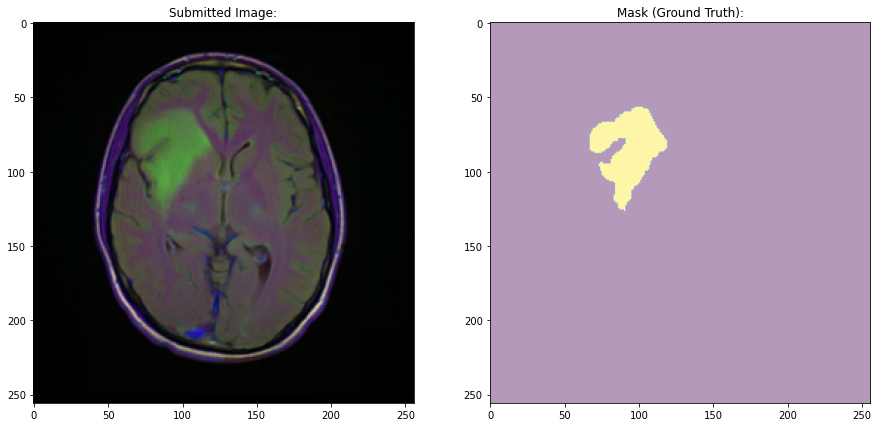

In [38]:
# HT Study
ht_image = Image.open("../../jordan/brain-mri/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_10.tif")
ht_mask = Image.open("../../jordan/brain-mri/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_10_mask.tif")

ht_sample = (ht_image, ht_mask)
ht_tensor_sample = PairedToTensor(ht_sample)
ht_img_array = ht_tensor_sample[0].numpy()

f, axarr = plt.subplots(1,2, figsize=(15, 15))
axarr[0].imshow(ht_tensor_sample[0].permute(1, 2, 0))
axarr[0].title.set_text(f'Submitted Image:')
axarr[1].imshow(ht_tensor_sample[1].permute(1, 2, 0), alpha=0.4)
axarr[1].title.set_text(f'Mask (Ground Truth):')



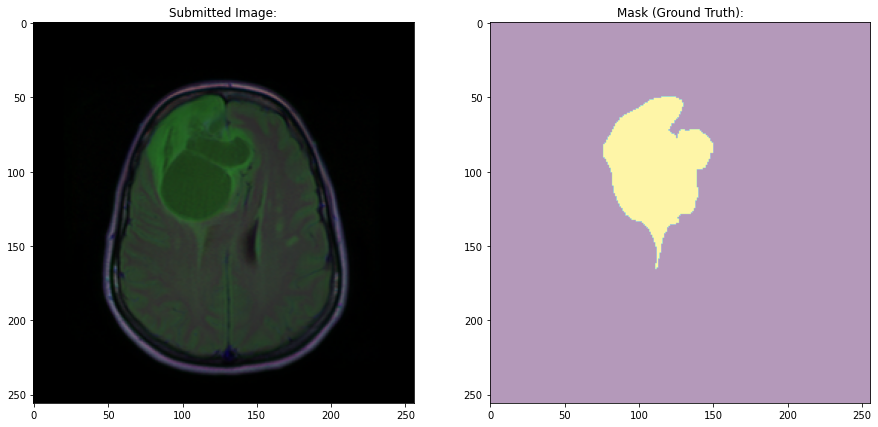

In [39]:
# DU Study
du_image = Image.open("../../jordan/brain-mri/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_18.tif")
du_mask = Image.open("../../jordan/brain-mri/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_18_mask.tif")

du_sample = (du_image, du_mask)
du_tensor_sample = PairedToTensor(du_sample)
du_img_array = du_tensor_sample[0].numpy()

f, axarr = plt.subplots(1,2, figsize=(15, 15))
axarr[0].imshow(du_tensor_sample[0].permute(1, 2, 0))
axarr[0].title.set_text(f'Submitted Image:')
axarr[1].imshow(du_tensor_sample[1].permute(1, 2, 0), alpha=0.4)
axarr[1].title.set_text(f'Mask (Ground Truth):')


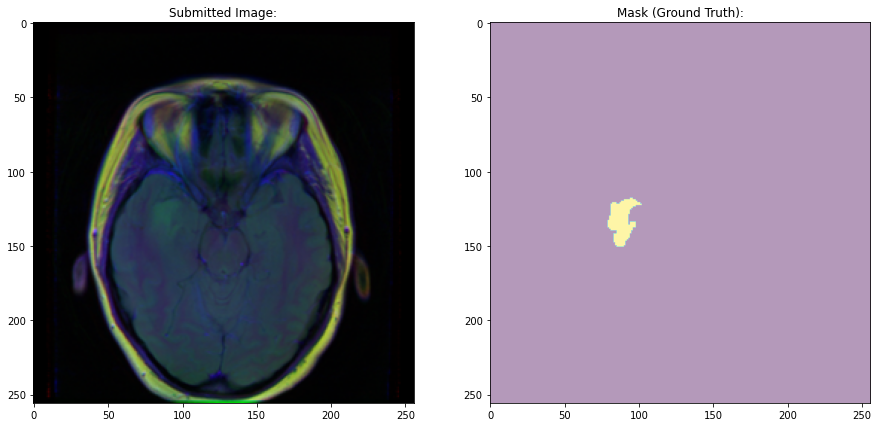

In [40]:
# CS Study

#image = Image.open("../../jordan/brain-mri/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_9.tif")
#mask = Image.open("../../jordan/brain-mri/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_9_mask.tif")

cs_image = Image.open("../../jordan/brain-mri/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_10.tif")
cs_mask = Image.open("../../jordan/brain-mri/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_10_mask.tif")

cs_sample = (cs_image, cs_mask)
cs_tensor_sample = PairedToTensor(cs_sample)
cs_img_array = cs_tensor_sample[0].numpy()

f, axarr = plt.subplots(1,2, figsize=(15, 15))
axarr[0].imshow(cs_tensor_sample[0].permute(1, 2, 0))
axarr[0].title.set_text(f'Submitted Image:')
axarr[1].imshow(cs_tensor_sample[1].permute(1, 2, 0), alpha=0.4)
axarr[1].title.set_text(f'Mask (Ground Truth):')

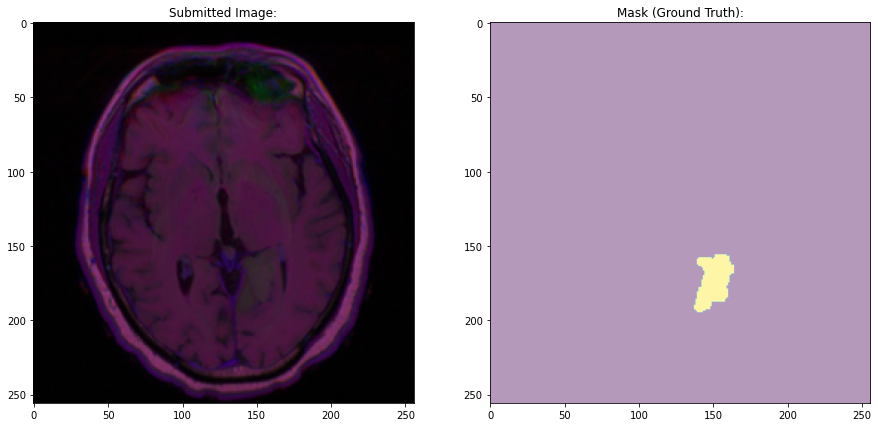

In [41]:
# FG Study
fg_image = Image.open("../../jordan/brain-mri/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_18.tif")
fg_mask = Image.open("../../jordan/brain-mri/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_18_mask.tif")

fg_sample = (fg_image, fg_mask)
fg_tensor_sample = PairedToTensor(fg_sample)
fg_img_array = fg_tensor_sample[0].numpy()

f, axarr = plt.subplots(1,2, figsize=(15, 15))
axarr[0].imshow(fg_tensor_sample[0].permute(1, 2, 0))
axarr[0].title.set_text(f'Submitted Image:')
axarr[1].imshow(fg_tensor_sample[1].permute(1, 2, 0), alpha=0.4)
axarr[1].title.set_text(f'Mask (Ground Truth):')